# Data analysis

**Execute the cell below. By running this cell, a dataset will be loaded from `patents.csv` file. There are three numpy arrays in this dataset:**
- `category`: the category to which a patent belongs 
- `patent_number`: a unique identifier for each patetnt
- `patent features`: a vector of 16 features describing several properties of each patent


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('patents.csv')
patent_features = df['patent_embedding'].to_numpy()
features_array = []
for i in range(patent_features.size):
    feature = str(patent_features[i])
    feature = feature.replace(r'\n', '')
    features_array.append(
        np.array(feature.split()[1:-1], dtype='float')[:16]
    )
patent_features = np.stack(features_array)
patent_category = df['category'].to_numpy()
patent_number = df['publication_number'].to_numpy()

<hr />

1- Which patent has the highest norm? (Eucledian distance from origin)


In [2]:
def norm(v):
    sum = 0
    for i in v:
        sum += i**2
    sum **= 0.5
    return sum
    
patent_features_norm_list = []
for i in patent_features:
    patent_features_norm_list.append(norm(i))
maxnorm_index = np.argmax(patent_features_norm_list)
print(patent_number[maxnorm_index])

CH-527846-A


2- Find the two patents that are the farthest from eachother.

In [3]:
def distance(v,w):
    sum = 0
    for i in range(len(v)):
        sum += (v[i]-w[i])**2
    sum **= 0.5
    return sum

In [6]:
def distance(v,w):
    sum = 0
    for i in range(len(v)):
        sum += (v[i]-w[i])**2
    sum **= 0.5
    return sum

n = len(patent_features)
max_points={"i":-1, "j":-1, "dest":0}
for i in range(n):
    for j in range(i+1,n):
        dst = distance(patent_features[i],patent_features[j])
        if dst > max_points["dest"]:
            max_points = {"i":i, "j":j, "dest":dst}
print("first patent", patent_number[max_points["i"]],"second patent", patent_number[max_points["j"]],"maximum_distance", max_points["dest"])

{'i': 1661, 'j': 9236, 'dest': 0.5612983586484407}


In [4]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

def farthest_points(points):
    # Calculate pairwise distances
    pairwise_distances = squareform(pdist(points))
    # Find the indices of the two farthest points
    idx_max = np.unravel_index(np.argmax(pairwise_distances), pairwise_distances.shape)
    # Return the two farthest points and their distance
    p1_index = np.where(patent_features == points[idx_max[0]])[0][0]
    p2_index = np.where(patent_features == points[idx_max[1]])[0][0]
    max_distance = pairwise_distances[idx_max]
    return patent_number[p1_index], patent_number[p2_index], max_distance

p1, p2, max_distance = farthest_points(patent_features)
print("first patent", p1, "second patent", p2, "maximum_distance", max_distance)

first patent KR-100793527-B1 second patent US-3240764-A maximum_distance 0.5612983586484407


3- Write a function that, given a patent number, finds its nearest neighbour.


In [5]:
def nearest_nneighbour(pn):
    index = np.where(patent_number == pn)[0][0]
    pf = patent_features[index]
    min_point={"index":0, "dest":distance(pf, patent_features[0])}
    for i in range(len(patent_features)):
        dst = distance(pf, patent_features[i])
        if dst < min_point["dest"] and dst != 0:
            min_point={"index":i, "dest":distance(pf, patent_features[i])}
    return patent_number[min_point["index"]], min_point["dest"]

mnpnt, dest = nearest_nneighbour("CH-527846-A")
print("nearest neighbour", mnpnt, "distance", dest)

nearest neighbour KR-20010012196-A distance 0.1252962179701647


4- For each patent category, find the cluster center. This quantity is computed by taking average of all patents associated with each cluster.

In [6]:
categories = []
for i in patent_category:
    if i not in categories:
        categories.append(i)
results = []
for i in categories:
    count = 0
    sum = 0
    for j in range(len(patent_category)):
        if i == patent_category[j]:
            count += 1
            sum += norm(patent_features[j])
    cluster_av = sum/count
    results.append((i, cluster_av))
for i in results:
    print("category", i[0], "avrage", i[1])

category 1 avrage 0.13408030936722637
category 6 avrage 0.13426804805770412
category 0 avrage 0.1450858421278388
category 2 avrage 0.17691974197064822
category 4 avrage 0.13361326635902038
category 3 avrage 0.15337138585662585
category 7 avrage 0.13193580022827328
category 5 avrage 0.1602139323292626


5- How many patents have a nearest neighbour that is in the same category?

In [7]:
from scipy.spatial import distance

distances = distance.cdist(patent_features, patent_features, metric='euclidean')
diagonal_matrix = np.eye(len(patent_features))
distances += diagonal_matrix
nearest_neighbors = np.argmin(distances, axis=1)
count = 0
for i in range(len(patent_features)):
    if patent_category[i] == patent_category[nearest_neighbors[i]]:
        count += 1
print(count)

13000


6- What is the average and std of distances between every pair of patents?


In [8]:
from scipy.spatial import distance

distances = distance.cdist(patent_features, patent_features, metric='euclidean')
distances_1d = np.reshape(distances, (len(distances)**2,))
av = np.mean(distances_1d)
std = np.std(distances_1d)
print("avrage", av, "std", std)

avrage 0.1774779588870755 std 0.06172153433074445


7- What is the average and std of distances between every pair of patents within a category?
Using these calculated quantities, which cluster do you think is more condensed? Which one is more scattered?

In [9]:
from scipy.spatial import distance

def distances_functin(category_patent_features):
    distances = distance.cdist(category_patent_features, category_patent_features, metric='euclidean')
    distances_1d = np.reshape(distances, (len(distances)**2,))
    return np.mean(distances_1d), np.std(distances_1d)

categories_dict = {i:None for i in categories} 
for i in categories_dict:
    category_lst = []
    for j in range(len(patent_category)):
        if patent_category[j] == i:
            category_lst.append(patent_features[j])
    categories_dict[i] = category_lst
categories_properties = []
for i in categories_dict:
    categories_properties.append((i, distances_functin(categories_dict[i])))
categories_std = []
for i in categories_properties:
    print(i)
    categories_std.append((i[0], i[1][1]))
categories_std.sort(key = lambda x: x[1])
print("max std",categories_std[-1])
print("min std",categories_std[0])

(1, (0.10235593475072612, 0.030560683465341895))
(6, (0.1040055310233456, 0.03180215536017749))
(0, (0.13098792252469746, 0.03973015614729102))
(2, (0.14095499322691948, 0.04403433221841342))
(4, (0.13610883703695129, 0.04026897604426641))
(3, (0.13874011203724912, 0.04483107158434705))
(7, (0.13052366960262599, 0.03853325352892595))
(5, (0.13459851471369638, 0.04241648037596702))
max std (3, 0.04483107158434705)
min std (1, 0.030560683465341895)


8- What is your analysis from this dataset?

خوشه بندی داده‌ها به نحو مناسبی انجام شده است زیرا مشاهده میشود که مرکزیت(میانگین) و پراکندگی(انحراف معیار) داده‌ها در خوشه های مختلف مقادیر نزدیک بهمی دارند

9- Identify and visualize the distribution of patent categories.

In [46]:
categories_dict = {i:None for i in categories} 
for i in categories_dict:
    category_lst = []
    for j in range(len(patent_category)):
        if patent_category[j] == i:
            category_lst.append(patent_features[j])
    categories_dict[i] = category_lst
categories_norm_dict = {i:None for i in categories} 
for i in categories_dict:
    category_norm_list = []
    for j in categories_dict[i]:
        category_norm_list.append(norm(j))
    categories_norm_dict[i] = category_norm_list

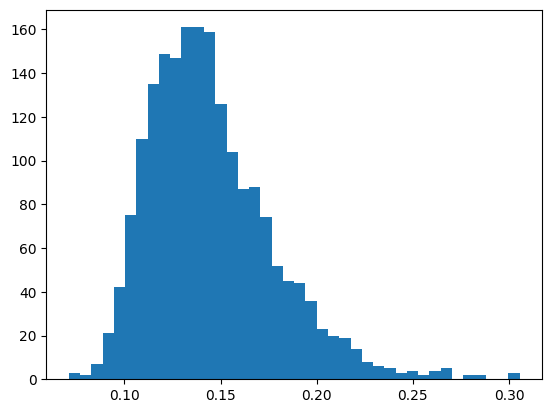

In [47]:
category_0 = categories_norm_dict[0]
plt.hist(category_0, bins=40)
plt.show()

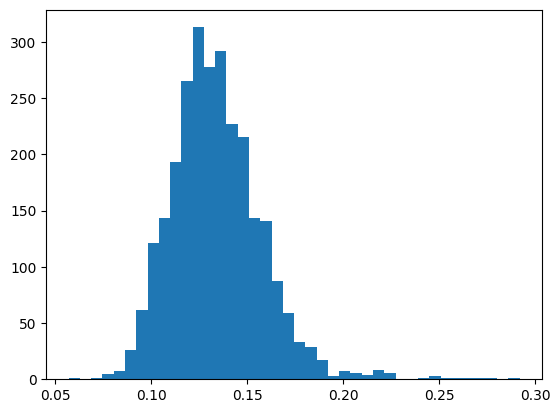

In [48]:
category_1 = categories_norm_dict[1]
plt.hist(category_1, bins=40)
plt.show()

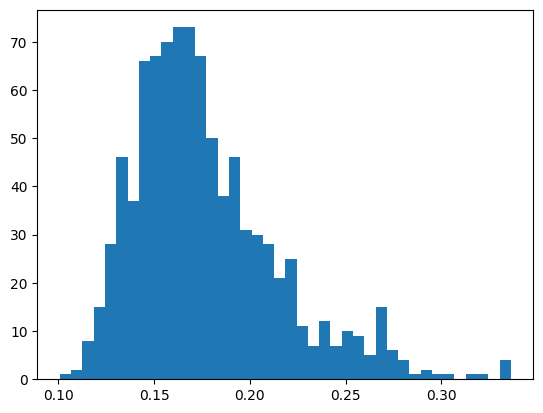

In [49]:
category_2 = categories_norm_dict[2]
plt.hist(category_2, bins=40)
plt.show()

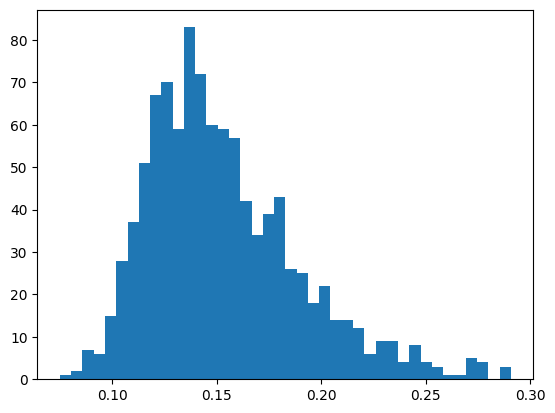

In [50]:
category_3 = categories_norm_dict[3]
plt.hist(category_3, bins=40)
plt.show()

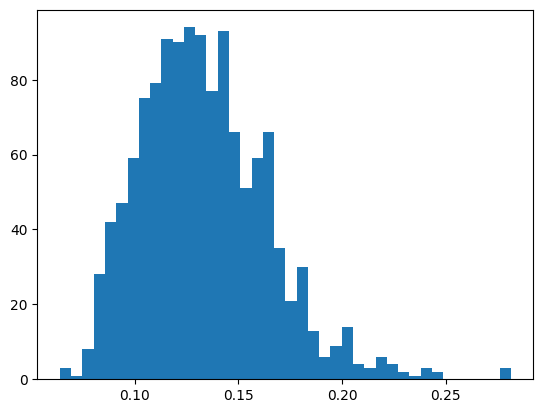

In [51]:
category_4 = categories_norm_dict[4]
plt.hist(category_4, bins=40)
plt.show()

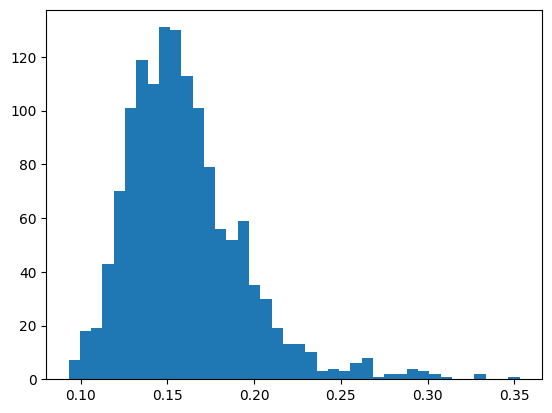

In [52]:
category_5 = categories_norm_dict[5]
plt.hist(category_5, bins=40)
plt.show()

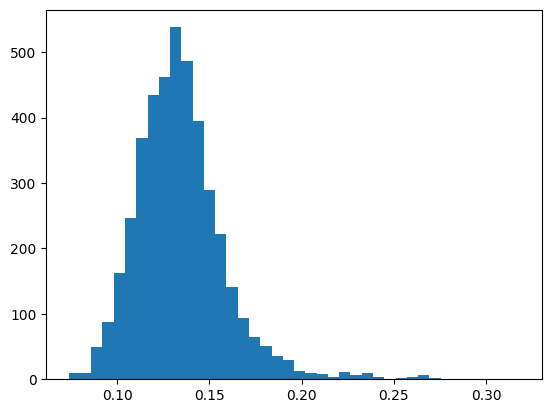

In [53]:
category_6 = categories_norm_dict[6]
plt.hist(category_6, bins=40)
plt.show()

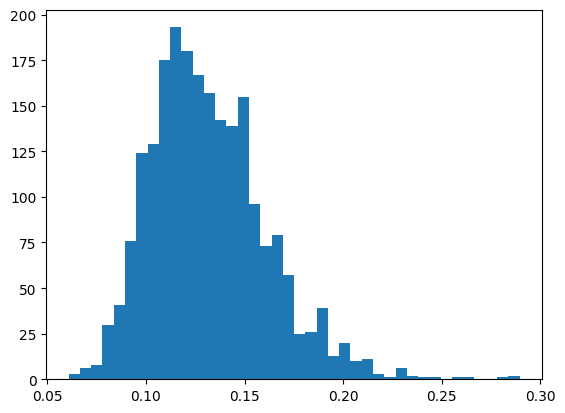

In [54]:
category_7 = categories_norm_dict[7]
plt.hist(category_7, bins=40)
plt.show()

بنظر میرسد فاصله‌ها در همه خوشه‌ها با کمی اغماض توزیعی راست چوله دارند

10- Perform Principal Component Analysis (PCA) on the patent features to reduce dimensionality. (Bonus)